In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [2]:
train_csv_path=r'Training_set.csv'
test_csv_path=r'Testing_set.csv'
train_img_path=r'train'
test_img_path=r'Testing_set.csv'
df=pd.read_csv(train_csv_path)
# modify df to have column names filepaths and labels
df.columns=['filepaths', 'labels']
# modify df so entries in filepaths column are the full path to the image file
df['filepaths']=df['filepaths'].apply(lambda x: os.path.join(train_img_path, x))
# split df into a train_df , a valid_df and a test_df
train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])     
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  11340   test_df length:  630   valid_df length:  630
The number of classes in the dataset is:  15
            CLASS               IMAGE COUNT 
           calling                  756     
           clapping                 756     
           cycling                  756     
           dancing                  756     
           drinking                 756     
            eating                  756     
           fighting                 756     
           hugging                  756     
           laughing                 756     
      listening_to_music            756     
           running                  756     
           sitting                  756     
           sleeping                 756     
           texting                  756     
         using_laptop               756     
calling  has the most images=  756   calling  has the least images=  756
average height=  198  average width=  258 aspect ratio=  0.7662875270813989


In [3]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=300 # since each class has more than 300 images all classes will be trimmed to have 300 images per class
min_samples=300
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  300  and the minimum samples in any class is  300


In [4]:
working_dir=r'./'
img_size=(200,260)
batch_size=30 # We will use EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 4500 validated image filenames belonging to 15 classes.          for train generator 
Found 630 validated image filenames belonging to 15 classes.           for valid generator 
Found 630 validated image filenames belonging to 15 classes.           for test generator 
test batch size:  70   test steps:  9  number of classes :  15


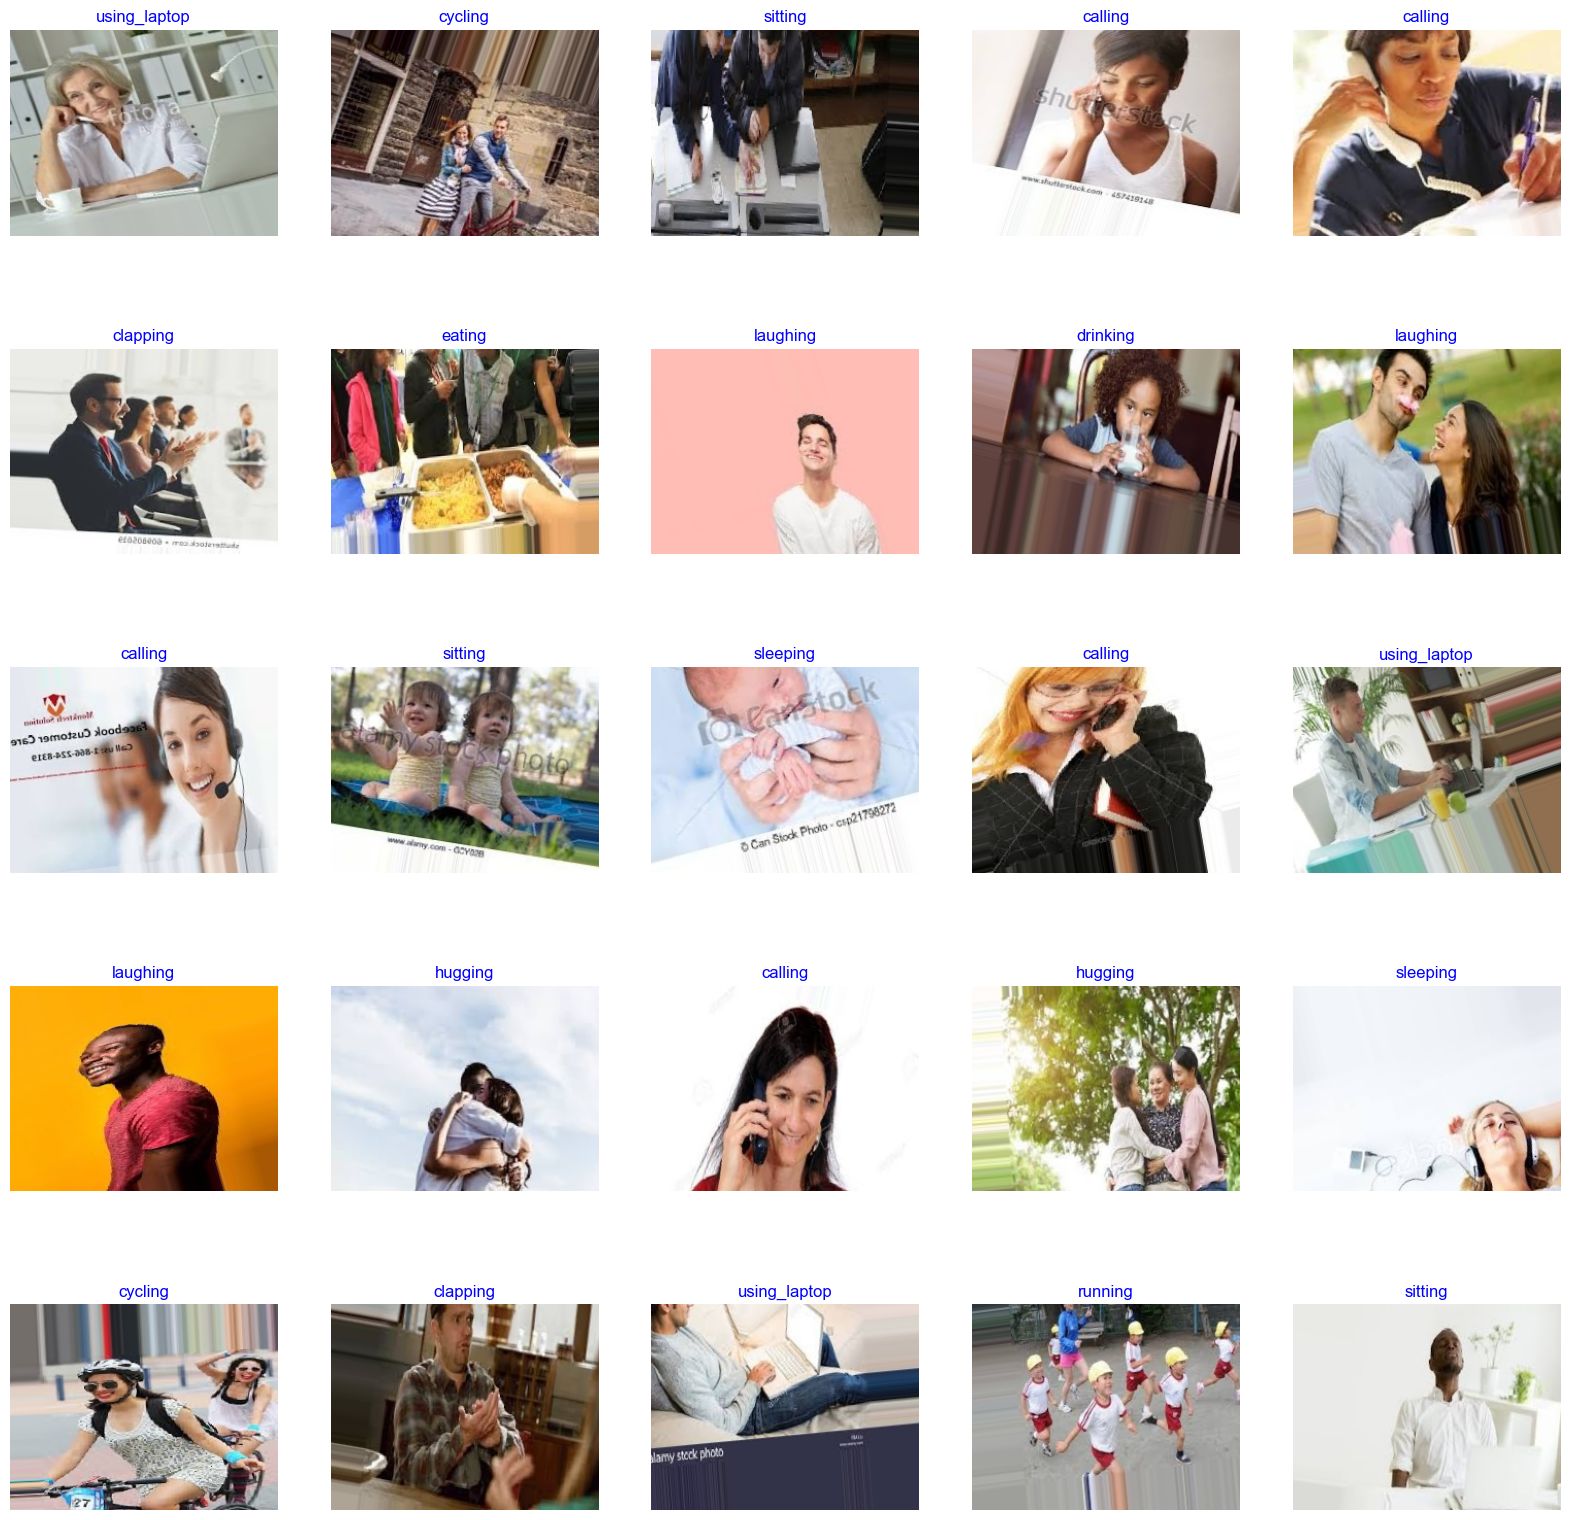

In [5]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [6]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

In [7]:
epochs=40

rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop]

In [8]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 200, 260, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 200, 260, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 200, 260, 3)  0           ['normalization[0][0]']      

 block2a_expand_conv (Conv2D)   (None, 100, 130, 14  3456        ['block1b_add[0][0]']            
                                4)                                                                
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 100, 130, 14  576        ['block2a_expand_conv[0][0]']    
 ization)                       4)                                                                
                                                                                                  
 block2a_expand_activation (Act  (None, 100, 130, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 101, 131, 14  0          ['block2a_expand_activation[0][0]
 g2D)     

 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 50, 65, 192)  1728       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 50, 65, 192)  768        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 50, 65, 192)  0          ['block2c_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block3b_activation (Activation  (None, 25, 33, 288)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 288)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3b_se_reshape[0][0]']     
          

 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 288)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block4a_se_reduce[0][0]']      
          

                                                                                                  
 block4c_se_excite (Multiply)   (None, 13, 17, 576)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 13, 17, 96)   55296       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 13, 17, 96)  384         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 13, 17, 96)   0           ['block4c_project_bn[0][0]']     
          

                                                                                                  
 block4e_project_bn (BatchNorma  (None, 13, 17, 96)  384         ['block4e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4e_drop (Dropout)         (None, 13, 17, 96)   0           ['block4e_project_bn[0][0]']     
                                                                                                  
 block4e_add (Add)              (None, 13, 17, 96)   0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 13, 17, 576)  55296       ['block4e_add[0][0]']            
          

                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 13, 17, 816)  3264       ['block5c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5c_expand_activation (Act  (None, 13, 17, 816)  0          ['block5c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, 13, 17, 816)  20400      ['block5c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5c_b

 ivation)                                                                                         
                                                                                                  
 block5e_dwconv (DepthwiseConv2  (None, 13, 17, 816)  20400      ['block5e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5e_bn (BatchNormalization  (None, 13, 17, 816)  3264       ['block5e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5e_activation (Activation  (None, 13, 17, 816)  0          ['block5e_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block6b_activation (Activation  (None, 7, 9, 1392)  0           ['block6b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1392)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6b_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6d_se_reduce[0][0]']      
                                                                                                  
 block6d_se_excite (Multiply)   (None, 7, 9, 1392)   0           ['block6d_activation[0][0]',     
                                                                  'block6d_se_expand[0][0]']      
          

                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_se_excite (Multiply)   (None, 7, 9, 1392)   0           ['block6f_activation[0][0]',     
                                                                  'block6f_se_expand[0][0]']      
                                                                                                  
 block6f_project_conv (Conv2D)  (None, 7, 9, 232)    322944      ['block6f_se_excite[0][0]']      
                                                                                                  
 block6f_project_bn (BatchNorma  (None, 7, 9, 232)   928         ['block6f_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block7b_drop (Dropout)         (None, 7, 9, 384)    0           ['block7b_project_bn[0][0]']     
                                                                                                  
 block7b_add (Add)              (None, 7, 9, 384)    0           ['block7b_drop[0][0]',           
                                                                  'block7a_project_bn[0][0]']     
                                                                                                  
 top_conv (Conv2D)              (None, 7, 9, 1536)   589824      ['block7b_add[0][0]']            
                                                                                                  
 top_bn (BatchNormalization)    (None, 7, 9, 1536)   6144        ['top_conv[0][0]']               
                                                                                                  
 top_activ

In [10]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/40
150/150 [==============================] - 653s 4s/step - loss: 8.0315 - accuracy: 0.4996 - val_loss: 7.1522 - val_accuracy: 0.6143 - lr: 0.0010
Epoch 2/40
150/150 [==============================] - 633s 4s/step - loss: 5.9148 - accuracy: 0.6653 - val_loss: 5.1997 - val_accuracy: 0.7063 - lr: 0.0010
Epoch 3/40
150/150 [==============================] - 632s 4s/step - loss: 4.4879 - accuracy: 0.7460 - val_loss: 4.0180 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 4/40
150/150 [==============================] - 639s 4s/step - loss: 3.4280 - accuracy: 0.7964 - val_loss: 3.2255 - val_accuracy: 0.7365 - lr: 0.0010
Epoch 5/40
150/150 [==============================] - 629s 4s/step - loss: 2.6272 - accuracy: 0.8320 - val_loss: 2.5514 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 6/40
150/150 [==============================] - 631s 4s/step - loss: 1.9934 - accuracy: 0.8733 - val_loss: 2.1053 - val_accuracy: 0.7651 - lr: 0.0010
Epoch 7/40
150/150 [==============================] - 631s 4s/st

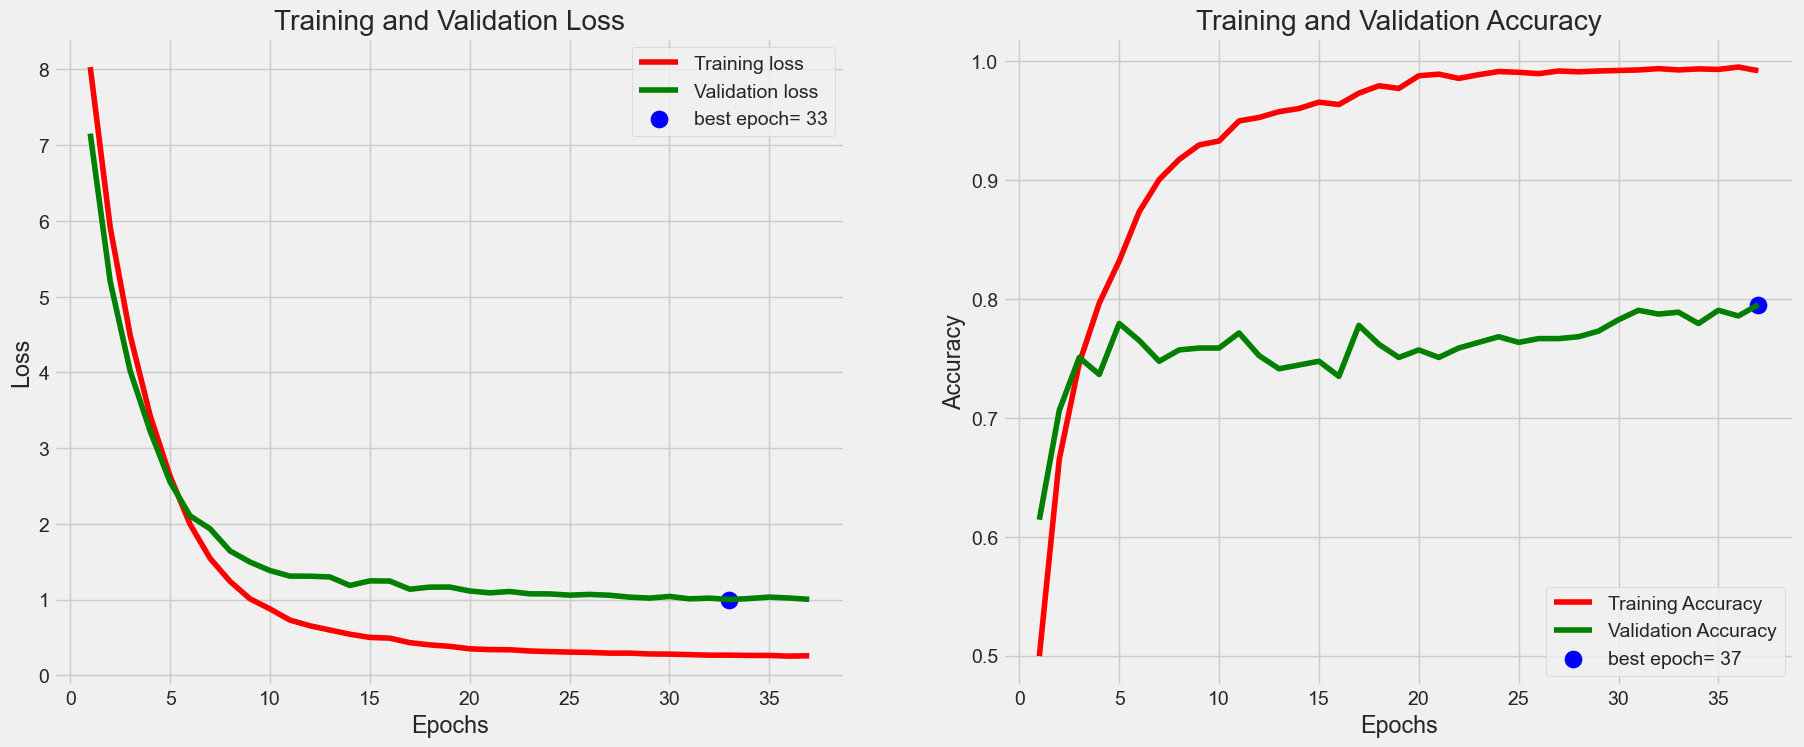

In [11]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

9/9 [==============================] - 22s 2s/step
there were 111 in 630 tests for an accuracy of  82.38


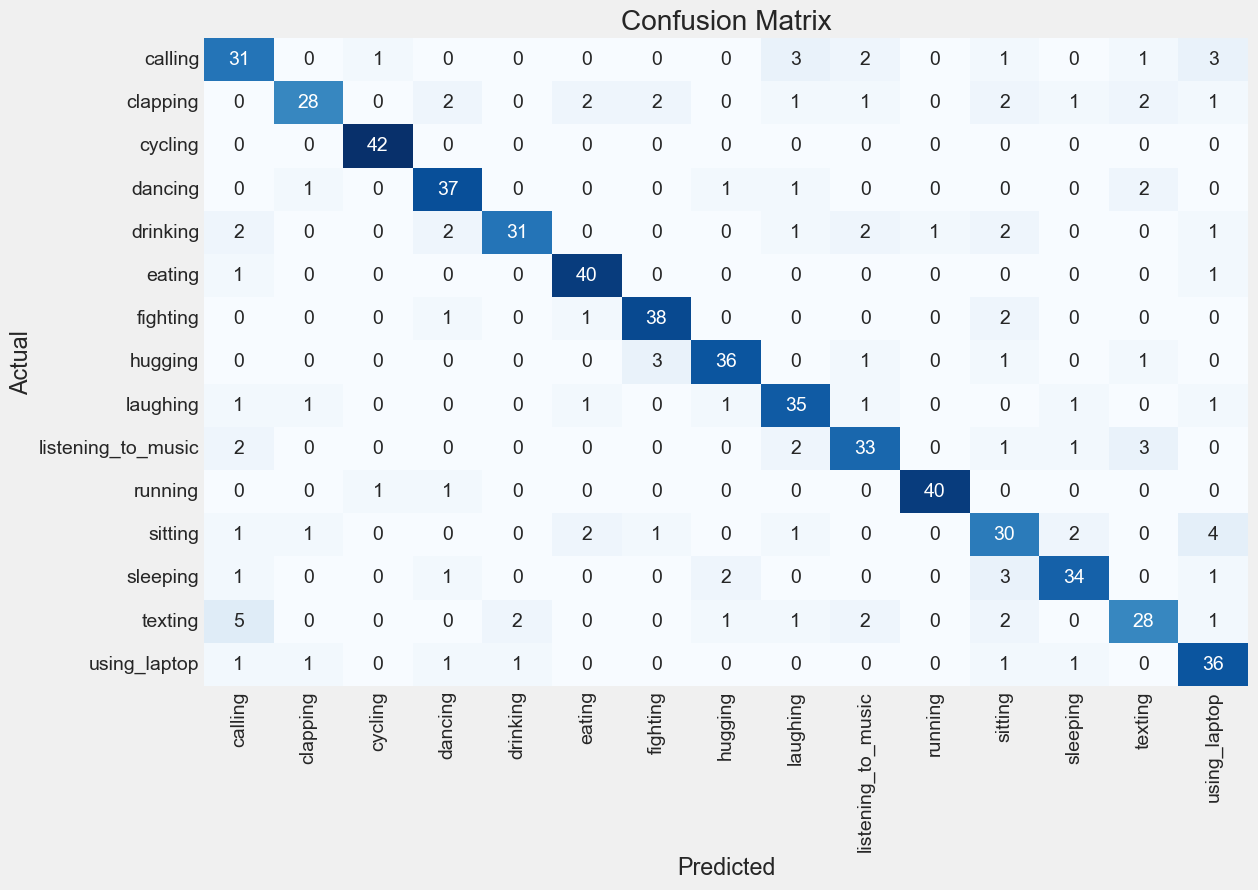

Classification Report:
----------------------
                     precision    recall  f1-score   support

           calling     0.6889    0.7381    0.7126        42
          clapping     0.8750    0.6667    0.7568        42
           cycling     0.9545    1.0000    0.9767        42
           dancing     0.8222    0.8810    0.8506        42
          drinking     0.9118    0.7381    0.8158        42
            eating     0.8696    0.9524    0.9091        42
          fighting     0.8636    0.9048    0.8837        42
           hugging     0.8780    0.8571    0.8675        42
          laughing     0.7778    0.8333    0.8046        42
listening_to_music     0.7857    0.7857    0.7857        42
           running     0.9756    0.9524    0.9639        42
           sitting     0.6667    0.7143    0.6897        42
          sleeping     0.8500    0.8095    0.8293        42
           texting     0.7568    0.6667    0.7089        42
      using_laptop     0.7347    0.8571    0.7912   

In [12]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)         
            true_index=test_gen.labels[i]  # labels are integer values
            if pred_index != true_index: # a misclassification has occurred                                           
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)